# 1. Importing Required Libraries

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, LSTM

# 2. Loading and Preparing Data

Loading the dataset containing stock prices. The dataset is read using pandas.

In [2]:
filename = 'Dataset/stock_data.csv'
fname = os.path.basename(filename)
data = pd.read_csv(filename)
data

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL
...,...,...,...,...,...,...,...,...
19581,2017-11-06,178.56000,180.45000,178.31000,180.17000,13275578,0,FB
19582,2017-11-07,180.50000,180.74800,179.40300,180.25000,12903836,0,FB
19583,2017-11-08,179.79000,180.35000,179.11000,179.56000,10467606,0,FB
19584,2017-11-09,178.31000,179.40000,177.09000,179.30000,12602188,0,FB


# 3. Filtering Stock Data

Here, we filter the dataset based on the selected stock name. As in below cell I have selected FB, similarlly we change it to AAPL, MSFT or TSLA

In [3]:
stock_list = ['AAPL', 'FB', 'MSFT', 'TSLA']
stock_name = stock_list[1]      # Selecting 'FB' (Facebook)
if fname == 'NSE-Tata-Global-Beverages-Limited.csv':
    dataset = pd.read_csv(filename,usecols=['Date','Open','High','Low','Close'])
    dataset["Date"] = pd.to_datetime(dataset.Date,format="%Y-%m-%d")
    dataset.index = dataset['Date']
    dataset = dataset.sort_index(ascending=True, axis=0)
    dataset.fillna(0, inplace = True)
    stock_name = 'NSE-Tata-Global-Beverages-Limited'
else:
    dataset = pd.read_csv(filename,usecols=['Date','Open','High','Low','Close','Stock'])
    dataset["Date"] = pd.to_datetime(dataset.Date,format="%Y-%m-%d")
    dataset.index = dataset['Date']
    dataset = dataset.sort_index(ascending=True, axis=0)
    dataset.fillna(0, inplace = True)
    dataset = dataset.loc[dataset['Stock'] == stock_name]

dataset

,Date,Open,High,Low,Close,Stock
Date,,,,,,
2012-05-18,2012-05-18,42.05,45.000,38.000,38.23,FB
2012-05-21,2012-05-21,36.53,36.660,33.000,34.03,FB
2012-05-22,2012-05-22,32.61,33.590,30.940,31.00,FB
2012-05-23,2012-05-23,31.37,32.500,31.360,32.00,FB
2012-05-24,2012-05-24,32.95,33.210,31.770,33.03,FB
...,...,...,...,...,...,...
2017-11-06,2017-11-06,178.56,180.450,178.310,180.17,FB
2017-11-07,2017-11-07,180.50,180.748,179.403,180.25,FB
2017-11-08,2017-11-08,179.79,180.350,179.110,179.56,FB


# 4. Data Visualization

Data Normalization: We use MinMaxScaler to scale the values between 0 and 1, making them ready for LSTM.

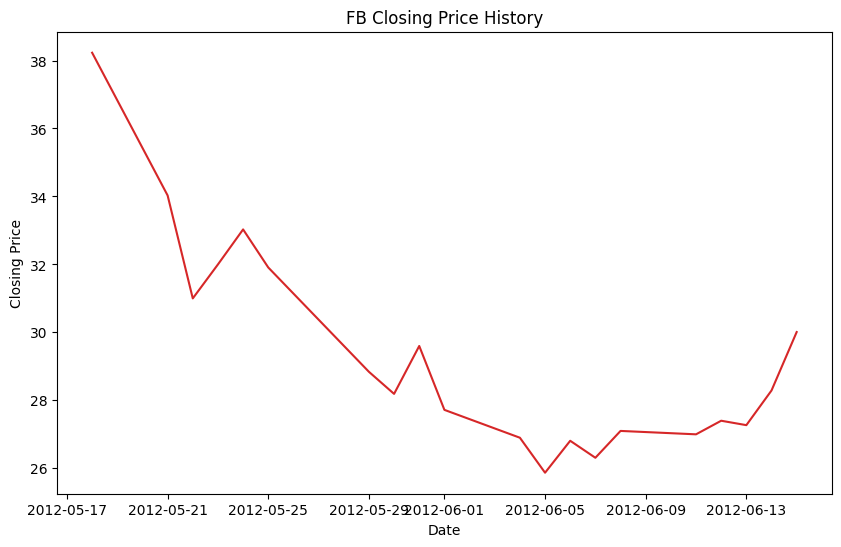

In [4]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(dataset.Date[0:20], dataset.Close[0:20], color='tab:red')
plt.gca().set(title=stock_name+" Closing Price History", xlabel='Date', ylabel="Closing Price")
plt.show()

# 5. Data Preprocessing

Data Normalization: We use MinMaxScaler to scale the values between 0 and 1, making them ready for LSTM.<br>
After Normalization the dataset is splitting into 80% training and 20% testing dataset.

In [5]:
sc = MinMaxScaler(feature_range = (0, 1))
dataset = dataset.values
Y = dataset[:,4:5]
X = dataset[:,1:4]
X = sc.fit_transform(X)
Y = sc.fit_transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Preprocessing Completed")
print("Dataset Normalized Values : "+str(X))
print("Dataset Train & Test Split. 80% dataset used for training and 20% for testing")
print("80% training size : "+str(X_train.shape[0]))
print("20% testing size : "+str(X_test.shape[0]))

Dataset Preprocessing Completed
Dataset Normalized Values : [[0.14590942 0.16236409 0.12544473]
 [0.11230825 0.11170504 0.09477365]
 [0.08844655 0.09305716 0.08213716]
 ...
 [0.98435598 0.98451072 0.99104404]
 [0.97534697 0.97874021 0.97865293]
 [0.97559046 0.97691794 0.98398969]]
Dataset Train & Test Split. 80% dataset used for training and 20% for testing
80% training size : 1104
20% testing size : 277


In [6]:
mse = []

In [7]:
def calculateMSE(algorithm, predict, y_test):
    mse_value = mean_squared_error(y_test,predict)
    mse.append(mse_value)
    print(algorithm+" MSE value : "+str('{:.6f}'.format(mse_value))+"\n")
    print(algorithm+" Accuracy  : "+str(1 - mse_value)+"\n\n")
    
    predict = sc.inverse_transform(predict)
    predict = predict.ravel()
    labels = y_test.reshape(y_test.shape[0],1)
    labels = sc.inverse_transform(labels)
    labels = labels.ravel()
    labels = labels[0:100]
    predict = predict[0:100]
    for i in range(0,20):
        print(algorithm+" Predicted Stock Price: "+str(predict[i])+" Original Stock Price : "+str(labels[i]))

    #plotting predicted and original RUL values
    plt.plot(labels, color = 'red', label = 'Original Stock Price')
    plt.plot(predict, color = 'green', label = 'Predicted Stock Price')
    plt.title(algorithm+' Predicted Stock Price Graph')
    plt.xlabel('Test Data Size')
    plt.ylabel('Predicted Stock Price')
    plt.legend()
    plt.show()

# 6. ANN Model 

In [8]:
if os.path.exists('model/ann_model.json'):
    with open('model/ann_model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        ann = model_from_json(loaded_model_json)
    json_file.close()
    ann.load_weights("model/ann_model.weights.h5")
    ann.predict(X_test)   
else:
    #creating neural object with 50 and 50 neurons and learning rate is 0.005
    ann = Sequential()
    #defining neural network with 50 neurons
    ann.add(Dense(50, activation='relu', input_shape=(X_train.shape[1],)))
    ann.add(Dense(50, activation='relu'))#50 neurons
    ann.add(Dense(1))
    ann.compile(optimizer="adam", loss='mean_squared_error')
    hist = ann.fit(X_train, y_train, epochs = 1, batch_size = 8, validation_data=(X_test, y_test))
    ann.save_weights('model/ann_model.weights.h5')            
    model_json = ann.to_json()
    with open("model/ann_model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
    f = open('model/ann_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
#performing prediction on test data using ANN   
predict = ann.predict(X_test)
calculateMSE("ANN", predict, y_test)

C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0418 - val_loss: 4.1230e-05


FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'model\ann_model.weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

# 7. LSTM Model
We construct a Long Short-Term Memory (LSTM) model with multiple layers and Dropout to prevent overfitting. <br>
Model Training: The model is trained using the training dataset with one epoch for testing. <br>
Prediction: We use the trained model to make predictions on the stock prices. <br>
Saving & Loading Model: Save the model architecture in JSON format and the trained weights in HDF5 format.<br>
Load previously saved model and weights for future predictions.

In [ ]:
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

if os.path.exists('model/lstm_model.json'):
    with open('model/lstm_model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        lstm = model_from_json(loaded_model_json)
    json_file.close()
    lstm.load_weights("model/lstm_model.weights.h5")
    predict = lstm.predict(X_test1)  
else:
    #training with LSTM algorithm and saving trained model and LSTM refrence assigned to regression variable
    lstm = Sequential()
    #defining 32 neurons
    lstm.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train1.shape[1], X_train1.shape[2])))
    #0.2 as the drop out
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units = 50, return_sequences = True)) #16 another layer neurons
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units = 50, return_sequences = True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units = 50))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units = 1))
    lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist = lstm.fit(X_train1, y_train, epochs = 1, batch_size = 8, validation_data=(X_test1, y_test))
    lstm.save_weights('model/lstm_model.weights.h5')            
    model_json = lstm.to_json()
    with open("model/lstm_model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
    f = open('model/lstm_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
#performing prediction on test data    
predict = lstm.predict(X_test1)
calculateMSE("LSTM", predict, y_test)

# 8. Comparison Graphs
Comparing performance of ANN and LSTM to know which one is better fit for stock price prediction

In [ ]:
height = mse
bars = ('ANN MSE','LSTM MSE')
y_pos = np.arange(len(bars)) 
plt.bar(y_pos, height, color=['green', 'brown'])
plt.xticks(y_pos, bars)
plt.ylabel("MSE Value")  # Label y-axis
plt.xlabel("Models")  # Label x-axis
plt.title("ANN & LSTM MSE Comparison")
plt.show()

In [ ]:
plt.pie(mse, labels=bars, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title("Proportional MSE Contribution of ANN & LSTM")
plt.show()

In [ ]:
plt.plot(bars, mse, marker='o', linestyle='dashed', color='purple')
plt.xlabel("Models")
plt.ylabel("MSE Value")
plt.title("ANN vs LSTM MSE Trend")
plt.grid(True)
plt.show()